# RNN (Lecture 11-12)

专门处理序列数据的 **循环神经网络 (Recurrent Neural Networks, RNN)**。

## 1. RNN的基本概念

*   **为什么需要RNN?**: 传统的神经网络（如全连接网络或CNN）通常处理的是固定大小的输入，并且假定输入之间是独立的。然而，对于像文本、语音、视频这类具有时序关系的数据，我们需要一种能够处理序列信息并记忆历史信息的模型。
*   **核心思想**: RNN 引入了一个 **“记忆”** 或 **“内部状态” (Internal State)**，通常称为隐藏状态 `h`。这个状态在处理序列的每一步都会被更新，并传递到下一步。

## 2. RNN的结构与类型

RNN可以根据输入和输出序列的长度关系，分为几种不同的结构：
*   **一对一 (one-to-one)**: 传统的单输入单输出网络。
*   **一对多 (one-to-many)**: 单个输入，产生一个序列输出（例如：**图像描述生成**，输入一张图，输出一句话）。
*   **多对一 (many-to-one)**: 一个序列输入，产生单个输出（例如：**视频行为分类**，输入一段视频帧，判断视频中的动作类别）。
*   **多对多 (many-to-many)**:
    *   同步的多对多（例如：**视频逐帧分类**）。
    *   异步的多对多（例如：**机器翻译**，输入一个序列，输出另一个序列）。

## 3. RNN的数学原理

RNN的核心在于其 **循环更新** 的公式。在每个时间步 `t`：

1.  **更新隐藏状态 (Hidden State Update)**: 新的隐藏状态 $h_t$ 由 **上一个时间步的隐藏状态** $h_{t-1}$ 和 **当前时间步的输入** $x_t$ 共同决定。

    $h_t = f_W(h_{t-1}, x_t)$

    *   $f_W$ 是一个函数，通常是一个激活函数（如 `tanh`），$W$ 是需要学习的参数。
    *   **关键点**: 所有时间步共享 **同一套参数** $W$。

2.  **计算输出 (Output)**: 当前时间步的输出 $y_t$ 由当前的隐藏状态 $h_t$ 决定。

    $y_t = f_{W_{hy}}(h_t)$

*   **Vanilla RNN (简单RNN)** 的具体公式如下：

    $h_t = \tanh(W_{hh}h_{t-1} + W_{xh}x_t)$
    $y_t = W_{hy}h_t$

    *   $W_{hh}$: 隐藏状态到隐藏状态的权重矩阵。
    *   $W_{xh}$: 输入到隐藏状态的权重矩阵。
    *   $W_{hy}$: 隐藏状态到输出的权重矩阵。

## 4. RNN的训练：BPTT

*   **Backpropagation Through Time (BPTT)**:
    *   **思想**: 将RNN按时间步 **展开 (Unroll)** 成一个非常深的前馈神经网络，然后应用标准的反向传播算法来计算梯度。
    *   **问题**: 对于非常长的序列，展开后的网络会非常深，导致 **梯度消失/爆炸** 问题，并且计算和内存开销巨大。
*   **截断式BPTT (Truncated BPTT)**:
    *   **思想**: 为了解决长序列的问题，我们将序列切分成若干个较短的 **“块” (chunks)**。在处理每个块时，我们正常进行前向传播，但反向传播的梯度只回传固定的几步，而不是整个序列的开头。
    *   隐藏状态仍然会从一个块传递到下一个块，从而保留长期记忆，但梯度流被截断了。

## 5. 使用RNN生成序列 (Sampling)

训练好的RNN可以用来生成新的序列，例如生成文本。

*   **基本流程**:
    1.  给定一个初始输入（例如，一个起始字符）。
    2.  模型计算出下一个字符的概率分布。
    3.  从这个分布中 **采样 (Sample)** 一个字符作为输出。
    4.  将这个新生成的字符作为 **下一步的输入**，循环此过程。

*   **采样策略 (Sampling Strategies)**:
    1.  **Greedy Sampling (贪心采样)**: 在每一步都选择概率最高的那个token（字符）。
        *   **缺点**: 结果是确定性的，缺乏多样性，容易生成重复、无趣的序列。
    2.  **Weighted Sampling (加权采样)**: 根据模型输出的概率分布进行随机采样。
        *   **优点**: 可以生成多样化的、更有趣的序列。
        *   **缺点**: 可能会“意外”采到不合适的token，导致后续生成质量下降。

*   **搜索策略：Beam Search (集束搜索)**:
    *   **思想**: 这是介于贪心搜索和穷举搜索之间的一种折中方案。在每一步，不再只保留概率最高的一个选项，而是保留 **k个最可能** 的序列。在下一步，从这k个序列出发，继续扩展，并再次选出最优的k个。这个`k`就是 **beam size**。
    *   **优点**: 比贪心搜索效果更好，能找到更优的序列；比穷举搜索效率高得多。

## 6. 梯度消失与梯度爆炸问题 (Vanishing and Exploding Gradients)

这是训练原生 RNN (Vanilla RNN) 时的核心难题。

在 BPTT 过程中，梯度需要通过链式法则在时间步之间连乘。隐藏状态 `h_t` 对 `h_{t-1}` 的偏导数可以写作：
$$
\frac{\partial h_t}{\partial h_{t-1}} = \text{tanh}'(W_{hh}h_{t-1} + W_{xh}x_t)W_{hh}
$$
在多个时间步上，这个偏导数会不断地自乘。

*   **梯度消失 (Vanishing Gradients):** 如果权重矩阵 `W_{hh}` 的范数（或最大奇异值）小于1，经过多次连乘后，梯度会指数级衰减趋近于0。这导致模型无法学习到长距离的依赖关系，因为来自远方的梯度信号几乎无法传回。
*   **梯度爆炸 (Exploding Gradients):** 如果 `W_{hh}` 的范数大于1，梯度则会指数级增长，导致训练过程不稳定。这个问题相对容易解决，可以通过 **梯度裁剪 (Gradient Clipping)** 来控制梯度的大小。

**影响**

梯度消失使得模型只能学到短期的局部依赖，而无法捕捉序列中的长期关联。例如，在句子 "When she tried to print her tickets, ..., she finally printed her \_\_\_\_\_\_." 中，要正确预测出 "tickets"，模型需要记住句子开头的 "tickets"，但如果梯度消失了，这种长距离的联系就无法建立。


# LSTM(长短期记忆网络 Long Short-Term Memory)

LSTM 是一种特殊的 RNN 架构，旨在解决梯度消失问题，从而更好地捕捉长期依赖。

## **1. 核心结构：门控机制与细胞状态**

LSTM 的关键创新在于引入了 **细胞状态 (Cell State)** `c_t` 和三个 **门 (Gates)**。

*   **细胞状态 `c_t`:** 像一条传送带，信息可以在上面直接流过，只做一些微小的线性修改。这使得梯度可以很容易地在时间步之间传播而不发生衰减。
*   **门 (Gates):** 是一种让信息选择性通过的结构。它们由 sigmoid 激活函数和逐元素乘法组成。Sigmoid 函数输出一个介于 0 和 1 之间的值，表示允许多少信息通过（0 表示完全不允许，1 表示完全允许）。

LSTM 有三个门来保护和控制细胞状态：
1.  **遗忘门 (Forget Gate) `f_t`:** 决定从上一个细胞状态 `c_{t-1}` 中丢弃哪些信息。
2.  **输入门 (Input Gate) `i_t`:** 决定将哪些新信息存入细胞状态。它和一个 tanh 层一起工作，tanh 层创建一个候选值向量 `g_t`，然后由输入门决定更新多少。
3.  **输出门 (Output Gate) `o_t`:** 决定从细胞状态中输出什么作为当前时间步的隐藏状态 `h_t`。

#### **2. LSTM 的更新公式**
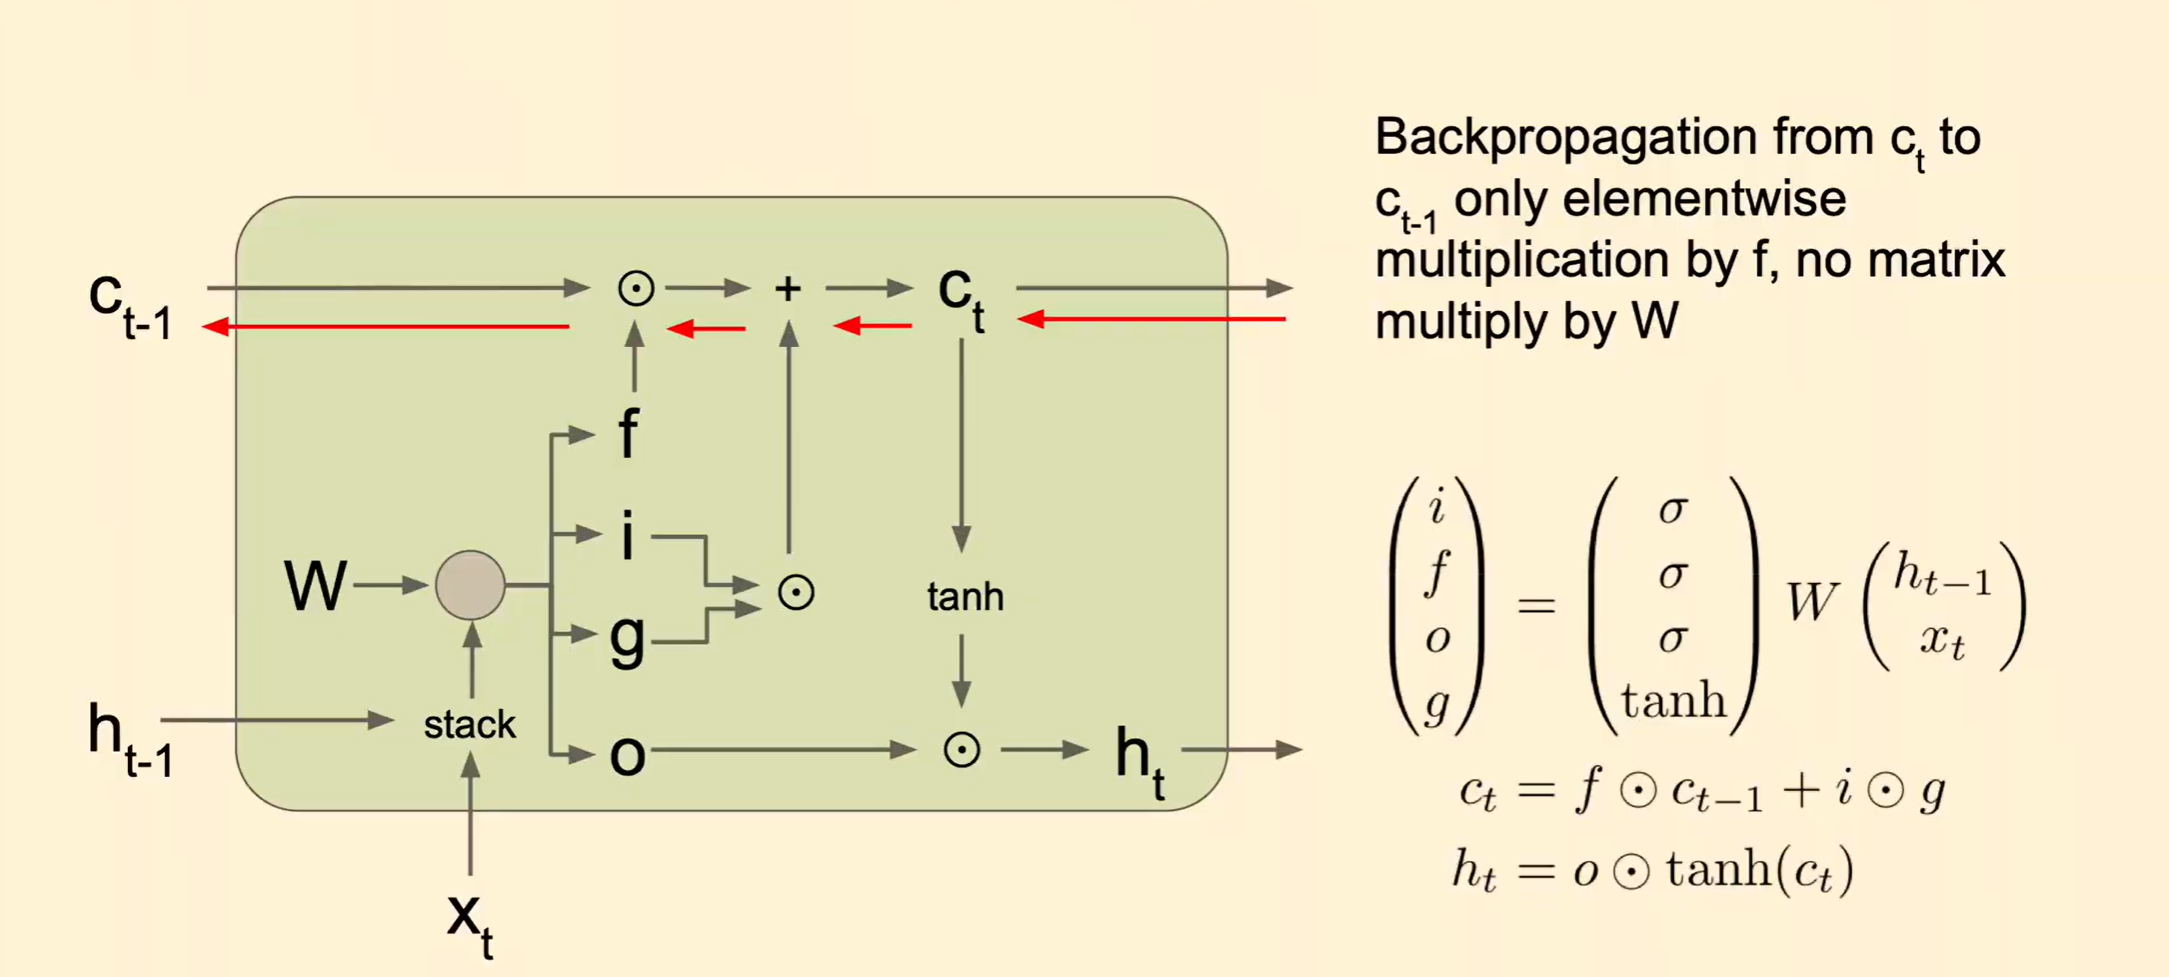

$$
\begin{pmatrix} i \\ f \\ o \\ g \end{pmatrix} = \begin{pmatrix} \sigma \\ \sigma \\ \sigma \\ \text{tanh} \end{pmatrix} W \begin{pmatrix} h_{t-1} \\ x_t \end{pmatrix}
$$
$$
c_t = f \odot c_{t-1} + i \odot g
$$
$$
h_t = o \odot \text{tanh}(c_t)
$$
其中 `σ` 是 Sigmoid 函数, `⊙` 表示逐元素相乘 (Hadamard product)。

#### **3. LSTM 如何解决梯度消失**

细胞状态的更新是加法形式的 (`c_t = f \odot c_{t-1} + ...`)。在反向传播时，从 `c_t` 到 `c_{t-1}` 的梯度路径上只有一个逐元素的乘法（乘以 `f_t`），没有矩阵乘法。通过控制遗忘门 `f_t` 的值（例如使其接近1），梯度就可以几乎无衰减地向前传播，从而形成 **"不间断的梯度流"**，这使得 LSTM 能够学习到长距离的依赖关系。

#### **4. 其他 RNN 变体：GRU**

**门控循环单元 (Gated Recurrent Unit - GRU)** 是 LSTM 的一个流行变体。它将遗忘门和输入门合并为一个“更新门”，结构比 LSTM 更简单，计算效率更高，在许多任务上表现与 LSTM 相当。


# 序列到序列模型 (Sequence to Sequence - Seq2Seq)

Seq2Seq 模型用于处理输入序列和输出序列长度可能不同的情况，例如机器翻译、对话系统等。它由两个主要部分组成：

1.  **编码器 (Encoder):** 一个 RNN，负责读取输入序列并将其压缩成一个固定长度的上下文向量 (context vector)，通常是编码器最后一个时间步的隐藏状态 `h_T`。
2.  **解码器 (Decoder):** 另一个 RNN，接收上下文向量作为初始隐藏状态，然后一步步地生成输出序列。

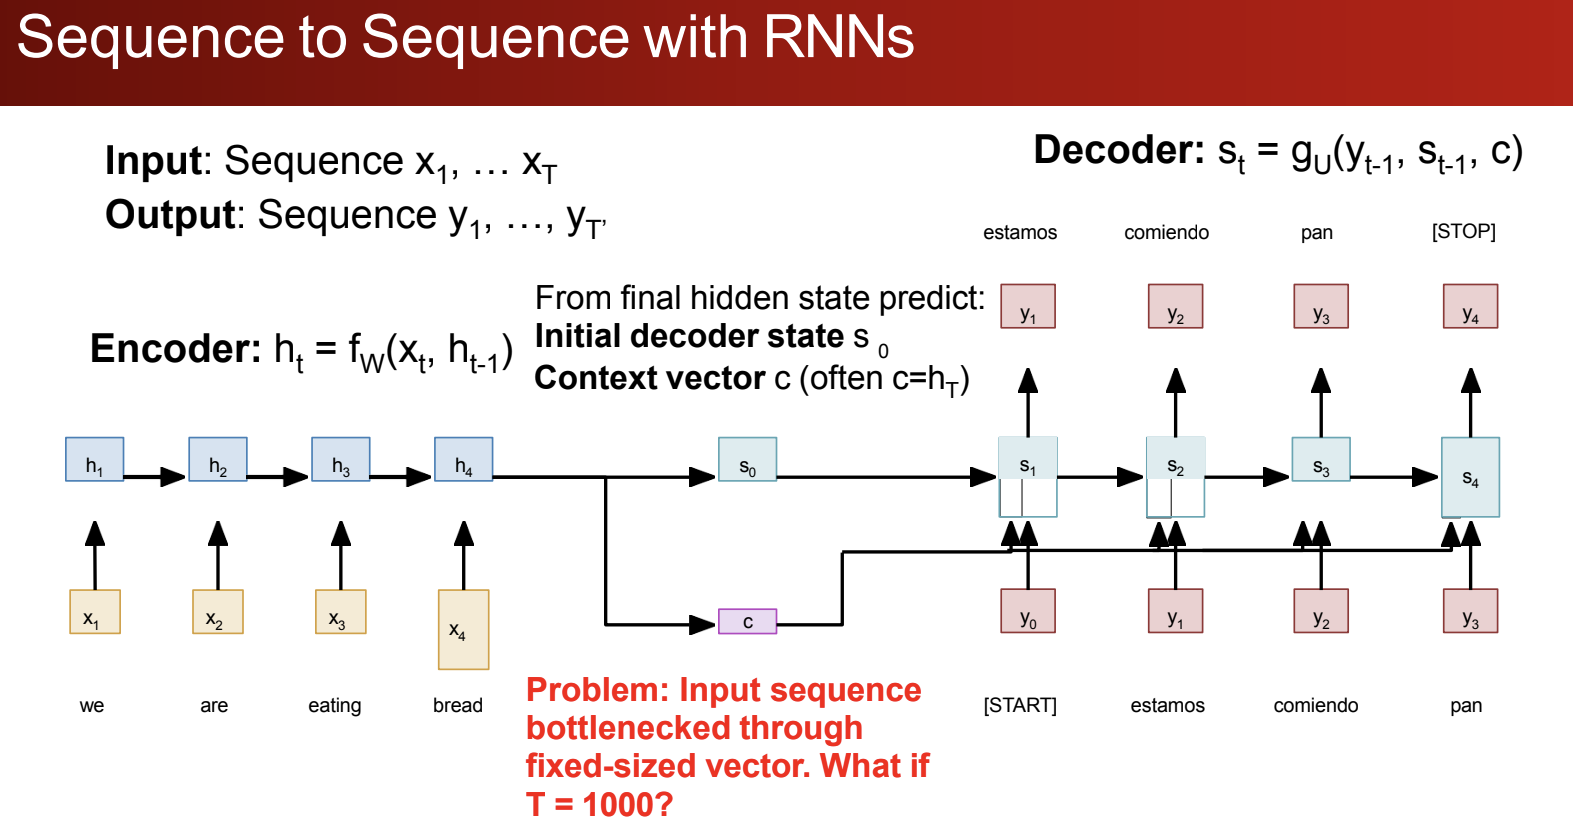

## **第一步：编码器（阅读员）的工作**

### 通俗理解

*   **任务**：阅读并理解整个英文句子。
*   **过程**：
    1.  阅读员（编码器）一个词一个词地读入英文句子 "we are eating bread"。
    2.  每读一个词，他就在脑子里更新一下对这句话的“理解”。这个“理解”在图中就是**隐藏状态** `h`。
    3.  读完 "we" 得到理解 `h1`，再读 "are" 更新理解为 `h2`，以此类推。
    4.  当他读完最后一个词 "bread" 时，他得到了最终的、对整个句子的**整体理解**，也就是 `h4`。

这个最终的 `h4` 非常关键，它相当于阅读员把整句话的精髓（语法、意思、时态等）压缩成了一个**摘要**。这个摘要在模型里被称为 **“上下文向量”（Context vector, 图中的 `c`）**。

### 具体实现方法
#### **1. 输入词向量 (Input Word Vectors): `x_1`, `x_2`, `x_3`, `x_4`**
*   **方块 `x_1` 代表什么？**
    *   是 "we" 这个词的**数学表示**，也就是一个**词向量 (Word Embedding)**。
    *   一个包含很多数字的列表，比如 `[0.1, -0.5, 0.8, ...]`。这个向量捕捉了 "we" 这个词的语义信息。计算机只能处理数字，所以必须做这个转换。
*   **从 "we" 到 `x_1` 的向上箭头代表什么？**
    *   这个箭头代表 **“词嵌入”** 的过程。模型有一个巨大的查询表（Embedding Layer），你输入一个词，它会返回这个词对应的向量。

#### **2. RNN 隐藏状态 (Hidden States): `h_1`, `h_2`, `h_3`, `h_4`**
*   **蓝色方块 `h_t` 代表什么？**
    *   它代表**编码器RNN在时间步 `t` 的隐藏状态**，也是一个向量。这个向量是模型在处理完第 `t` 个词后的“记忆”或“理解”。
*   **方块 `h_t` 内部发生了什么？**
    *   这个方块本身就是一个**RNN单元**（比如一个基础RNN单元或更复杂的LSTM单元）。它执行一个数学计算，这个计算由公式 `h_t = f_W(x_t, h_{t-1})` 定义。
    *   `f_W`: 代表RNN单元的函数。`W`是这个函数的**权重参数**，是模型通过大量数据训练学到的。
    *   `x_t`: 当前输入词的词向量（例如 `x_2`）。
    *   `h_{t-1}`: **上一个时间步的隐藏状态**（例如 `h_1`）。
*   **箭头代表什么？**
    *   **从 `x_t` 指向 `h_t` 的向上箭头**：表示将当前词的词向量 `x_t` 作为输入，送入RNN单元进行计算。
    *   **从 `h_{t-1}` 指向 `h_t` 的水平箭头**：它表示将上一步的“记忆” `h_{t-1}` 传递到当前一步，和当前输入 `x_t` 一起，共同计算出新的“记忆” `h_t`。

## **第二步：连接桥梁 - 中间**

### **1. 上下文向量 (Context Vector): `c`**
*   **紫色方块 `c` 代表什么？**
    *   它是一个向量，是整个输入句子的**最终摘要**。
*   **从 `h_4` 指向 `c` 的箭头代表什么？**
    *   表示一个简单的**复制操作**。编码器处理完最后一个词得到的最终隐藏状态 `h_4`，被直接作为上下文向量 `c`。所以，`c = h_4`。

### **2. 解码器初始状态 (Initial Decoder State): `s_0`**
*   **蓝色方块 `s_0` 代表什么？**
    *   它是**解码器RNN的初始隐藏状态**（可以理解为解码器开始工作前的“初始思路”），也是一个向量。
*   **从 `h_4` 指向 `s_0` 的箭头代表什么？**
    *   表示用编码器的最终状态 `h_4` 来**初始化**解码器的第一个状态。

## **第三步：解码器（写作员）的工作**

### 通俗理解

*   **任务**：根据阅读员给的“摘要”，写出对应的中文句子。
*   **过程**：
    1.  写作员（解码器）**唯一**能得到的信息，就是阅读员给他的那个“摘要” `c`。他用这个 `c` 来初始化自己的思考状态（图中的 `s0`）。
    2.  他开始写第一个字。他结合“摘要” `c` 和一个开始信号 `[START]`，觉得第一个词应该是“我们”（图中的 "estamos"）。
    3.  然后，他根据他刚写的“我们”和**同一个“摘要” `c`**，觉得下一个词应该是“正在吃”（图中的 "comiendo"）。
    4.  他不断重复这个过程：看一眼自己上一步写的词，再想一下那个**固定不变的“摘要” `c`**，然后写出下一个词。
    5.  直到他觉得句子完整了，就输出一个结束信号 `[STOP]`。

### 具体实现

#### **1. 解码器隐藏状态 (Hidden States): `s_1`, `s_2`, `s_3`, `s_4`**
*   **淡绿色方块 `s_t` 代表什么？**
    *   它代表**解码器RNN在时间步 `t` 的隐藏状态**，也是一个向量。它包含了到目前为止已经生成了哪些翻译内容，以及接下来要生成什么内容的“思考”。
*   **方块 `s_t` 内部发生了什么？**
    *   它也是一个RNN单元，执行 `s_t = g_U(y_{t-1}, s_{t-1}, c)` 的计算。注意，解码器有自己独立的权重 `U`。
*   **箭头代表什么？**
    *   **从 `s_{t-1}` 指向 `s_t` 的水平箭头**：和编码器一样，传递解码器自身的“记忆”。
    *   **从 `y_{t-1}` 指向 `s_t` 的向上箭头**：表示将**上一步生成的词**（比如用 `y_1` "estamos" 的词向量）作为当前步的输入。`y_0` 是一个特殊的 `[START]` 标志。
    *   **从 `c` 指向每个 `s_t` 的箭头**：这非常关键！它表示在**每一个解码步骤**，那个**固定不变的**上下文向量 `c` 都会被作为输入。解码器每生成一个词，都会被再次提醒原文的整体意思是什么。

#### **2. 输出词 (Output Words): `y_1`, `y_2`, `y_3`, `y_4`**
*   **红色方块 `y_t` 代表什么？**
    *   它代表模型在第 `t` 步**预测出的词**的词向量。
*   **从 `s_t` 指向 `y_t` 的向上箭头代表什么？**
    *   这代表**预测/生成**过程。
    1.  解码器的隐藏状态 `s_t` (一个向量) 会经过一个线性变换层和一个 **Softmax** 函数。
    2.  Softmax 函数会输出一个概率分布，即在整个词典中，每个词是下一个词的概率是多少。
    3.  模型选择概率最高的那个词作为输出（比如 "estamos"）。这个词的词向量就是 `y_t`。


## 问题：信息瓶颈 (information bottleneck)

整个英文句子的所有信息，都被强行压缩进了那个**固定大小**的“摘要”向量 `c` 里。

*   **打个比方**：让你听完一段很长的演讲（比如1000个词，`T=1000`），然后不许看稿子，只凭你脑子里的“最终印象”（也就是那个摘要 `c`），去复述整场演讲的每一个细节。
*   **这会发生什么？** 你很可能会忘记开头讲了什么，或者记错一些细节。因为你的大脑（一个固定大小的向量）很难完美记住所有信息。

这就是**信息瓶颈**：一个固定大小的向量 `c` 承载了太多的信息，导致信息丢失，尤其是对于长句子。写作员（解码器）在翻译句末内容时，可能已经忘记了句首的关键词。


# Attention

在没有注意力机制时，写作员只能依靠阅读员给他的**一份最终摘要 (`c`)** 来翻译整个句子。对于长句子来说，这份摘要的信息量根本不够。有了注意力机制，写作员不再依赖那份固定的摘要。在他准备写**每一个**中文词之前，他都会根据所标出当前最需要关注的部分，生成一份**全新的、为当前步骤量身定制的动态摘要**。

## 具体实现

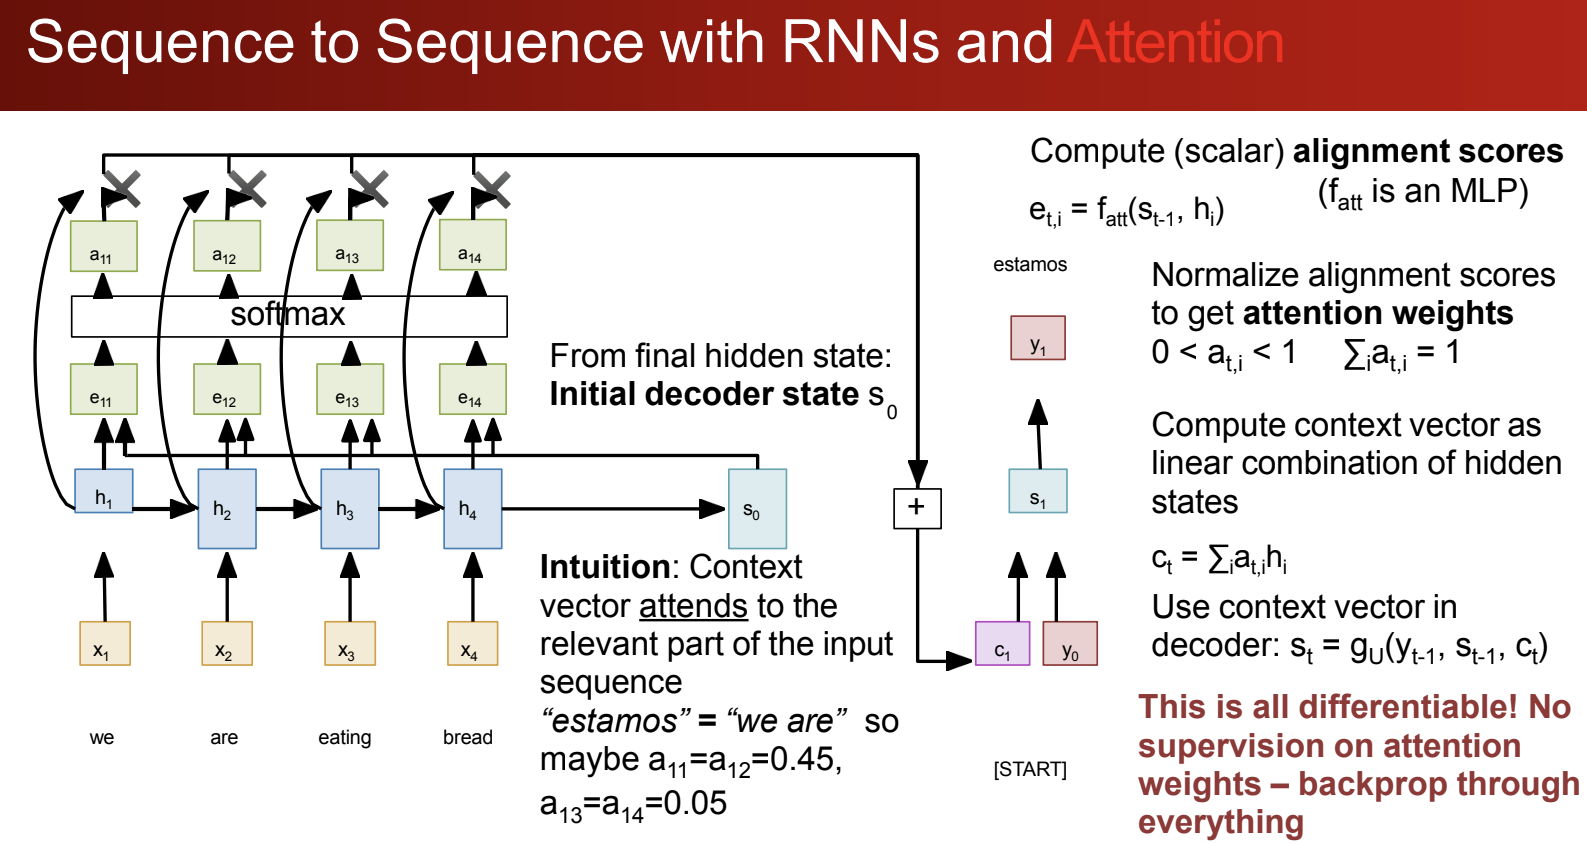

### **第1步：计算相关性**

*   **目的 (作用):** 判断原文中每个词（"we", "are", "eating", "bread"）对于**即将要生成的第一个西班牙语单词**有多重要。
*   **实现 (怎么做):**
    *   模型将解码器的当前思路 `s₀` 和原文中**每一个词的摘要**（`h₁`, `h₂`, `h₃`, `h₄`）分别进行一次“匹配度计算”。这个计算由一个小型神经网络 `f_att` 完成。
    *   `e₁₁ = f_att(s₀, h₁)`  => `s₀` 和 "we" 的相关性得分
    *   `e₁₂ = f_att(s₀, h₂)`  => `s₀` 和 "are" 的相关性得分
    *   ...以此类推，得到四个**对齐分数 (alignment scores)** `e₁₁`, `e₁₂`, `e₁₃`, `e₁₄`。
    *   这里的 `e` 就代表这个原始的、未经处理的“分数”。分数越高，代表相关性越强。

### **第2步：分配注意力**

*   **目的 (作用):** 将刚才得到的原始分数，转换成一个清晰的“注意力百分比”分布。
*   **实现 (怎么做):**
    *   使用 **Softmax** 函数。能把一组任意数值（比如 `[1.2, 1.5, 0.1, 0.3]`）转换成一组总和为1的概率值（比如 `[0.45, 0.45, 0.05, 0.05]`）。
    *   输出的 `a₁₁`, `a₁₂`, `a₁₃`, `a₁₄` 就是**注意力权重 (attention weights)**。

### **第3步：生成动态摘要**

*   **目的 (作用):** 根据刚刚分配好的注意力权重，生成一个**为当前步骤量身定制的上下文向量 `c₁`**。
*   **实现 (怎么做):**
    *   对原文所有词的摘要 (`h₁` 到 `h₄`) 进行**加权求和**。
    *   `c₁ = a₁₁*h₁ + a₁₂*h₂ + a₁₃*h₃ + a₁₄*h₄`
    *   由于 `a₁₁` 和 `a₁₂` 很大，而 `a₁₃` 和 `a₁₄` 很小，所以这个新的上下文向量 `c₁` 的内容，**绝大部分都来自于 `h₁` ("we") 和 `h₂` ("are")**。它是一个专门为翻译 "we are" 而定制的摘要。

### **第4步：生成翻译词**

*   **实现 (怎么做):**
    *   解码器RNN接收三个输入：上一步的思路 `s₀`，上一步生成的词 `y₀` ([START]信号)，以及我们刚计算出的**动态上下文向量 `c₁`**。
    *   通过 `s₁ = g_U(y₀, s₀, c₁)` 计算出新的思路 `s₁`。
    *   最后，`s₁` 经过Softmax层，预测出概率最高的词是 "estamos"，也就是 `y₁`。

### **BP**
整个注意力计算过程（打分、Softmax、加权求和）都是可微分的数学运算。这意味着我们可以用反向传播 (backprop) 来训练整个系统。